In [1]:
import networkx as nx;
import numpy as np;
import matplotlib.pyplot as plt;
import math;

# Giant components, percolation and robustness

## Giant component in the Erdős - Rényi model

### Simulations

First we are going to examine the emergence of the giant component in the Erdős-Rényi model as a function of the average degree $\left< k\right>$ simply by generating samples, and measuring the size of the largest connected component.

In [2]:
N, num_samp = 1000, 10;
k_list = np.arange(0.05,3.0,0.05);
av_lcc_size = [];
av_lcc_size.clear();
for k in k_list:
    print('k= ',k);
    comp_sizes = [];
    comp_sizes.clear();
    for i in range(0,num_samp):
        ER_graph = nx.generators.erdos_renyi_graph(N,k/(N-1.0));
        largest_comp_size = len(max(nx.connected_components(ER_graph), key = len));
        comp_sizes.append(largest_comp_size);
    av_lcc_size.append(np.mean(comp_sizes));

k=  0.05
k=  0.1
k=  0.15000000000000002
k=  0.2
k=  0.25
k=  0.3
k=  0.35000000000000003
k=  0.4
k=  0.45
k=  0.5
k=  0.55
k=  0.6000000000000001
k=  0.6500000000000001
k=  0.7000000000000001
k=  0.7500000000000001
k=  0.8
k=  0.8500000000000001
k=  0.9000000000000001
k=  0.9500000000000001
k=  1.0
k=  1.05
k=  1.1
k=  1.1500000000000001
k=  1.2000000000000002
k=  1.2500000000000002
k=  1.3
k=  1.35
k=  1.4000000000000001
k=  1.4500000000000002
k=  1.5000000000000002
k=  1.55
k=  1.6
k=  1.6500000000000001
k=  1.7000000000000002
k=  1.7500000000000002
k=  1.8
k=  1.85
k=  1.9000000000000001
k=  1.9500000000000002
k=  2.0
k=  2.05
k=  2.1
k=  2.15
k=  2.1999999999999997
k=  2.25
k=  2.3
k=  2.35
k=  2.4
k=  2.45
k=  2.5
k=  2.55
k=  2.6
k=  2.65
k=  2.7
k=  2.75
k=  2.8
k=  2.85
k=  2.9
k=  2.95


Before plotting the results it is a good idea to divide the recorded (average) component sizes with $N$, yielding the relative size of the largest component denoted by $S$ in the slides. (This is guaranteed to be between 0 and 1).

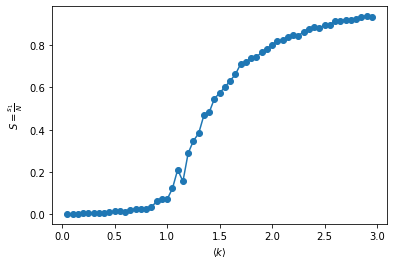

In [3]:
rel_lcc_size =[comp_size/N for comp_size in av_lcc_size];

plt.clf();
plt.plot(k_list,rel_lcc_size,'-o');
plt.xlabel(r'$\left< k\right>$');
plt.ylabel(r'$S=\frac{s_1}{N}$');
plt.show();

### Analytic curve

In the slides we derived an interesting equation for $S$ in the form of
$$
S=1-e^{-\left< k\right>S}.
$$
Although this cannot be solved in a simple explicit form, for any given value of $\left< k\right>$ we can calculate the value of $S$ numerically from this equation to any desired precision. Let's do this, and compare the obtained curve to the previous numerical results.

The simple trick is to turn the problem of finding roots of the above equation into the problem of finding zeros of
$$
g(S)=1-e^{-\left< k\right>S}-S.
$$
We are going to implement Newton's method for the detailes of this method see e.g.
https://en.wikipedia.org/wiki/Newtons_method

To do that we define the 3 functions:
- calculating $g(S)$ for given $\left< k\right>$ and $S$,
- calculating the derivative of $g(S)$ for given $\left< k\right>$ and $S$,
- and calculating the zero of the tangent of $g(S)$ for given $\left< k\right>$, $S$, and derivative at $S$.

In [4]:
def Calc_g_S(k,S):
    return 1.0-math.exp(-k*S)-S;

In [5]:
def Calc_g_deriv(k,S):
    return k*math.exp(-k*S)-1.0;

In [6]:
def Zero_of_g_tangent(k,S,deriv):
    return S-(1.0-math.exp(-k*S)-S)/deriv;

Everything is ready for putting together Newton's method:

In [7]:
def Anaytic_S_value(k):
    if k <= 1.0:
        return 0;
    else:
        S = 0.5;
        while (abs(Calc_g_S(k,S)) > 0.0000001):
            deriv = Calc_g_deriv(k,S);
            S = Zero_of_g_tangent(k,S,deriv);
        return S;

Now we can calculate the analytic $S$ for all $\left< k\right>$ values we used during the numberical simulations:

In [8]:
S_analytic = [Anaytic_S_value(k) for k in k_list];

And finally, we can replot the simulation results together with the analytic curve:

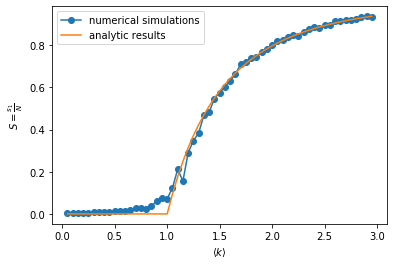

In [9]:
plt.clf();
plt.plot(k_list,rel_lcc_size,'-o',label ='numerical simulations');
plt.plot(k_list,S_analytic,'-',label='analytic results');
plt.xlabel(r'$\left< k\right>$');
plt.ylabel(r'$S=\frac{s_1}{N}$');
plt.legend();
plt.show();

## Percolation transition in the Erdős-Rényi model

As discussed on the slides, the above studied emergence of the giant component in the E-R model above the critical $\left< k\right>_{\rm crit}=1$ is like a **phase transition** (to be more specific, like a percolation phase transition), where the control parameter is $\left< k\right>$, and the order parameter is $S$. The susceptibility $\chi$ is a quantity that measurs how sensitive is the system with respect to small perturbations that try to drive the system from one phase to the other, and this quantity has a sharp peak at the transition point (critical point). As discussed in the slides, for the transition we are now interested in, the $\chi$ can be given as 
$$
\chi = \sum_{s_i \neq s_{\rm max}} s_i^2 p(s),
$$
where the summation runs over all the components except the largest one,  $s_i$ denotes the size of component $i$ and $p(s)$ is the component size distribution

Let's define a function that can calculate $\chi$ and $S$:

In [10]:
def Calc_chi_and_S(network):
    _network_N = network.number_of_nodes();
    _comps = nx.connected_components(network);
    _comp_sizes = [len(_comp) for _comp in _comps];
    _sort_c_sizes = sorted(_comp_sizes,reverse=True);
    _lcs = _sort_c_sizes[0]/_network_N;
    _chi = 0;
    if len(_sort_c_sizes) > 1:
        _chi = sum([_sort_c_sizes[i]*_sort_c_sizes[i] for i in range(1,len(_sort_c_sizes))]);
        return _chi/(len(_sort_c_sizes)),_lcs;
    else:
        return _chi,_lcs;

Let's re-run the simulations, but now recording the average value of $\chi$ as well.

In [11]:
N, num_samp = 5000, 1;
k_list = np.arange(0.05,3.0,0.05);
av_S,av_chi = [],[];
av_S.clear();
av_chi.clear();
for k in k_list:
    print('k= ',k);
    S_values, chi_values = [],[];
    S_values.clear();
    chi_values.clear();
    for i in range(0,num_samp):
        ER_graph = nx.generators.erdos_renyi_graph(N,k/(N-1.0));
        chi,S = Calc_chi_and_S(ER_graph);
        S_values.append(S);
        chi_values.append(chi);
    av_S.append(np.mean(S_values));
    av_chi.append(np.mean(chi_values));

k=  0.05
k=  0.1
k=  0.15000000000000002
k=  0.2
k=  0.25
k=  0.3
k=  0.35000000000000003
k=  0.4
k=  0.45
k=  0.5
k=  0.55
k=  0.6000000000000001
k=  0.6500000000000001
k=  0.7000000000000001
k=  0.7500000000000001
k=  0.8
k=  0.8500000000000001
k=  0.9000000000000001
k=  0.9500000000000001
k=  1.0
k=  1.05
k=  1.1
k=  1.1500000000000001
k=  1.2000000000000002
k=  1.2500000000000002
k=  1.3
k=  1.35
k=  1.4000000000000001
k=  1.4500000000000002
k=  1.5000000000000002
k=  1.55
k=  1.6
k=  1.6500000000000001
k=  1.7000000000000002
k=  1.7500000000000002
k=  1.8
k=  1.85
k=  1.9000000000000001
k=  1.9500000000000002
k=  2.0
k=  2.05
k=  2.1
k=  2.15
k=  2.1999999999999997
k=  2.25
k=  2.3
k=  2.35
k=  2.4
k=  2.45
k=  2.5
k=  2.55
k=  2.6
k=  2.65
k=  2.7
k=  2.75
k=  2.8
k=  2.85
k=  2.9
k=  2.95


We are going to plot $S$ and $\chi$ together as a function of $\left< k\right>$. However, since they are diferent quantities we are going to have 2 y axes on the plot.

<Figure size 432x288 with 0 Axes>

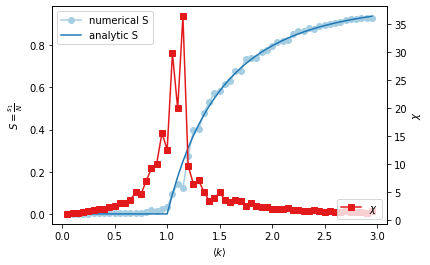

In [12]:
paired_color_map = plt.get_cmap('Paired');
paired_colors = [paired_color_map(x) for x in np.arange(0.5/12,1.0,1.0/12)];

plt.clf();
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(k_list,av_S,'o-',label = 'numerical S',color = paired_colors[0]);
ax1.plot(k_list,S_analytic,'-',label = 'analytic S',color = paired_colors[1]);
ax2.plot(k_list,av_chi,'s-',label = r'$\chi$',color = paired_colors[5]);

ax1.set_ylabel(r'$S=\frac{s_1}{N}$')
ax2.set_ylabel(r'$\chi$')
ax1.set_xlabel(r'$\left< k\right>$')
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower right')
plt.show();

## Robustness analysis of netwokrs

### Random node removal
Probably the simplest definition of network robustness is given by the resilience against random node removal, where the 'magnitude of resilience' can be measured by the fraction of (randomly chosen) nodes $f$ we have to remove in order to destroy the giant component in the network. 

In order to analyse this, we need to define a function implementing the random removal of nodes. In order to make our analysis faster, instead of removing one by one, we are going to remove larger chunks at once.   

In [13]:
def Random_node_remove(network,num_nodes_to_remove):
    _net_copy = network.copy();
    _nodes = _net_copy.nodes();
    _remove_list = np.random.choice(_nodes,num_nodes_to_remove,replace=False);
    for _node in _remove_list:
        _net_copy.remove_node(_node);
    return _net_copy;

We are going to try out this both on a real network and an E-R graph with the same size and link density.

First we read the network:

In [14]:
metabolic_net = nx.read_edgelist('metabolic.edgelist.txt');
print('N = ',metabolic_net.number_of_nodes(),' L= ',metabolic_net.number_of_edges());

N =  1039  L=  4741


OK, let's systematically remove nodes at random from this network, where we remove 10 nodes in one chunk. While doing this, we calculate and record $S$ and $\chi$.

In [15]:
met_copy = metabolic_net.copy();
step = 10;
met_rand_S, met_rand_chi, met_removed_N = [],[],[];
met_rand_S.clear();
met_rand_chi.clear();
met_removed_N.clear();
while (met_copy.number_of_nodes() > 2*step):
    met_copy = Random_node_remove(met_copy,step);
    print('current N = ',met_copy.number_of_nodes());
    chi,S = Calc_chi_and_S(met_copy);
    met_removed_N.append(metabolic_net.number_of_nodes() - met_copy.number_of_nodes());
    met_rand_chi.append(chi);
    met_rand_S.append(S);

current N =  1029
current N =  1019
current N =  1009
current N =  999
current N =  989
current N =  979
current N =  969
current N =  959
current N =  949
current N =  939
current N =  929
current N =  919
current N =  909
current N =  899
current N =  889
current N =  879
current N =  869
current N =  859
current N =  849
current N =  839
current N =  829
current N =  819
current N =  809
current N =  799
current N =  789
current N =  779
current N =  769
current N =  759
current N =  749
current N =  739
current N =  729
current N =  719
current N =  709
current N =  699
current N =  689
current N =  679
current N =  669
current N =  659
current N =  649
current N =  639
current N =  629
current N =  619
current N =  609
current N =  599
current N =  589
current N =  579
current N =  569
current N =  559
current N =  549
current N =  539
current N =  529
current N =  519
current N =  509
current N =  499
current N =  489
current N =  479
current N =  469
current N =  459
current N =

Before plotting the results, let's do the same for an E-R graph with the same N and same $\left< k\right>$.

In [16]:
met_ER = nx.generators.erdos_renyi_graph(metabolic_net.number_of_nodes(),nx.density(metabolic_net));

ER_copy = met_ER.copy();
ER_rand_S, ER_rand_chi, ER_removed_N = [],[],[];
ER_rand_S.clear();
ER_rand_chi.clear();
ER_removed_N.clear();
while (ER_copy.number_of_nodes() > 2*step):
    ER_copy = Random_node_remove(ER_copy,step);
    print('current N = ',ER_copy.number_of_nodes());
    chi,S = Calc_chi_and_S(ER_copy);
    ER_removed_N.append(met_ER.number_of_nodes() - ER_copy.number_of_nodes());
    ER_rand_chi.append(chi);
    ER_rand_S.append(S);

current N =  1029
current N =  1019
current N =  1009
current N =  999
current N =  989
current N =  979
current N =  969
current N =  959
current N =  949
current N =  939
current N =  929
current N =  919
current N =  909
current N =  899
current N =  889
current N =  879
current N =  869
current N =  859
current N =  849
current N =  839
current N =  829
current N =  819
current N =  809
current N =  799
current N =  789
current N =  779
current N =  769
current N =  759
current N =  749
current N =  739
current N =  729
current N =  719
current N =  709
current N =  699
current N =  689
current N =  679
current N =  669
current N =  659
current N =  649
current N =  639
current N =  629
current N =  619
current N =  609
current N =  599
current N =  589
current N =  579
current N =  569
current N =  559
current N =  549
current N =  539
current N =  529
current N =  519
current N =  509
current N =  499
current N =  489
current N =  479
current N =  469
current N =  459
current N =

<Figure size 432x288 with 0 Axes>

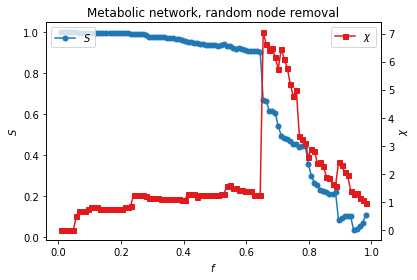

<Figure size 432x288 with 0 Axes>

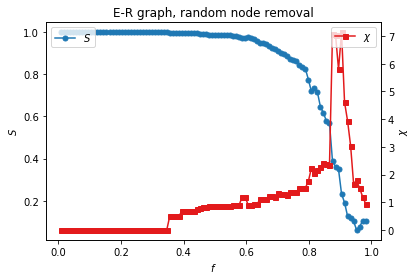

In [17]:
plt.clf();

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
met_f = [met_n/metabolic_net.number_of_nodes() for met_n in met_removed_N];

ax1.plot(met_f,met_rand_S,'o-',color = paired_colors[1],markersize=5,label =r'$S$');
ax2.plot(met_f,met_rand_chi,'s-',color = paired_colors[5],markersize=5,label = '$\chi$');
ax1.legend(loc = 'upper left');
ax1.set_ylabel('$S$');
ax2.legend(loc = 'upper right');
ax2.set_ylabel('$\chi$');
ax1.set_xlabel('$f$');
plt.title('Metabolic network, random node removal')
plt.show();

plt.clf();
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ER_f = [ER_n/met_ER.number_of_nodes() for ER_n in ER_removed_N];

ax1.plot(ER_f,ER_rand_S,'o-',color = paired_colors[1],markersize=5,label =r'$S$');
ax2.plot(ER_f,ER_rand_chi,'s-',color = paired_colors[5],markersize=5,label = '$\chi$');
ax1.legend(loc = 'upper left');
ax1.set_ylabel('$S$');
ax2.legend(loc = 'upper right');
ax2.set_ylabel('$\chi$');
ax1.set_xlabel('$f$');
plt.title('E-R graph, random node removal')
plt.show();


In case of the E-R graph, we **always** see a clear phase transition accompanied by a sharp peak in $\chi$. In contrast, for the metabolic network, usually we do not see such a well defined sharp peak, so the phase transition is missing, and the giant component remains to exist even when $f$ is relatively large. This means that the real network is more resilient against random node removal compared to an E-R graph.

**WARNING** Since the node removal is random, it may occure once in a while that with some luck we actually do manage to destroy the giant component in the metabolic network before $f$ is getting large. So in case you do see signs of a phase transition in your curves for the metabolic net, just re-run the cell calculating the data and re-plot.

### Targetted attack

Beside random node removal, a quite simple idea to attack a network is to take out nodes in the order of their degree. Let's have a look at that too.

First, we define a function implementing this:

In [18]:
def Attack_node_remove(network,num_nodes_to_remove):
    _net_copy = network.copy();
    _node_deg = {_node: network.degree(_node) for _node in network.nodes};
    _sort_nodes = sorted(_node_deg.items(), key = lambda x: x[1], reverse=True);
    _remove_list = [_sort_nodes[i][0] for i in range(0,num_nodes_to_remove)];
    for _node in _remove_list:
        _net_copy.remove_node(_node);
    return _net_copy;

Next we apply it to the metabolic network and also to its E-R counterpart.

In [19]:
met_copy = metabolic_net.copy();
step = 10;
met_atck_S, met_atck_chi, met_atck_N = [],[],[];
met_atck_S.clear();
met_atck_chi.clear();
met_atck_N.clear();
while (met_copy.number_of_nodes() > 2*step):
    met_copy = Attack_node_remove(met_copy,step);
    print('current N = ',met_copy.number_of_nodes());
    chi,S = Calc_chi_and_S(met_copy);
    met_atck_N.append(metabolic_net.number_of_nodes() - met_copy.number_of_nodes());
    met_atck_chi.append(chi);
    met_atck_S.append(S);

current N =  1029
current N =  1019
current N =  1009
current N =  999
current N =  989
current N =  979
current N =  969
current N =  959
current N =  949
current N =  939
current N =  929
current N =  919
current N =  909
current N =  899
current N =  889
current N =  879
current N =  869
current N =  859
current N =  849
current N =  839
current N =  829
current N =  819
current N =  809
current N =  799
current N =  789
current N =  779
current N =  769
current N =  759
current N =  749
current N =  739
current N =  729
current N =  719
current N =  709
current N =  699
current N =  689
current N =  679
current N =  669
current N =  659
current N =  649
current N =  639
current N =  629
current N =  619
current N =  609
current N =  599
current N =  589
current N =  579
current N =  569
current N =  559
current N =  549
current N =  539
current N =  529
current N =  519
current N =  509
current N =  499
current N =  489
current N =  479
current N =  469
current N =  459
current N =

In [20]:
met_ER = nx.generators.erdos_renyi_graph(metabolic_net.number_of_nodes(),nx.density(metabolic_net));

ER_copy = met_ER.copy();
ER_atck_S, ER_atck_chi, ER_atck_N = [],[],[];
ER_atck_S.clear();
ER_atck_chi.clear();
ER_atck_N.clear();
while (ER_copy.number_of_nodes() > 2*step):
    ER_copy = Attack_node_remove(ER_copy,step);
    print('current N = ',ER_copy.number_of_nodes());
    chi,S = Calc_chi_and_S(ER_copy);
    ER_atck_N.append(met_ER.number_of_nodes() - ER_copy.number_of_nodes());
    ER_atck_chi.append(chi);
    ER_atck_S.append(S);

current N =  1029
current N =  1019
current N =  1009
current N =  999
current N =  989
current N =  979
current N =  969
current N =  959
current N =  949
current N =  939
current N =  929
current N =  919
current N =  909
current N =  899
current N =  889
current N =  879
current N =  869
current N =  859
current N =  849
current N =  839
current N =  829
current N =  819
current N =  809
current N =  799
current N =  789
current N =  779
current N =  769
current N =  759
current N =  749
current N =  739
current N =  729
current N =  719
current N =  709
current N =  699
current N =  689
current N =  679
current N =  669
current N =  659
current N =  649
current N =  639
current N =  629
current N =  619
current N =  609
current N =  599
current N =  589
current N =  579
current N =  569
current N =  559
current N =  549
current N =  539
current N =  529
current N =  519
current N =  509
current N =  499
current N =  489
current N =  479
current N =  469
current N =  459
current N =

We can plot the results in a similar fashion to the random removal procedure:

<Figure size 432x288 with 0 Axes>

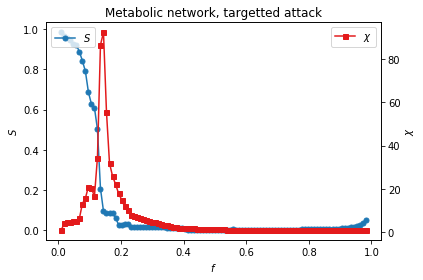

<Figure size 432x288 with 0 Axes>

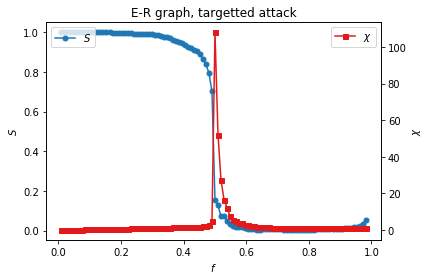

In [21]:
plt.clf();

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
met_atck_f = [met_n/metabolic_net.number_of_nodes() for met_n in met_atck_N];

ax1.plot(met_atck_f,met_atck_S,'o-',color = paired_colors[1],markersize=5,label =r'$S$');
ax2.plot(met_atck_f,met_atck_chi,'s-',color = paired_colors[5],markersize=5,label = '$\chi$');
ax1.legend(loc = 'upper left');
ax1.set_ylabel('$S$');
ax2.legend(loc = 'upper right');
ax2.set_ylabel('$\chi$');
ax1.set_xlabel('$f$');
plt.title('Metabolic network, targetted attack')
plt.show();

plt.clf();
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ER_atck_f = [ER_n/met_ER.number_of_nodes() for ER_n in ER_atck_N];

ax1.plot(ER_atck_f,ER_atck_S,'o-',color = paired_colors[1],markersize=5,label =r'$S$');
ax2.plot(ER_atck_f,ER_atck_chi,'s-',color = paired_colors[5],markersize=5,label = '$\chi$');
ax1.legend(loc = 'upper left');
ax1.set_ylabel('$S$');
ax2.legend(loc = 'upper right');
ax2.set_ylabel('$\chi$');
ax1.set_xlabel('$f$');
plt.title('E-R graph, targetted attack')
plt.show();


In this case we see very prominent signs of a phase transition for both networks. In case of the original network this comes at a much lower $f$ value compared to the E-R graph, thus, the real network is more vulnrable against targetted attack. 